## Causal relation presence detection: using BERT paragraph embeddings

### Causal relation presence detection: Trying to find is there a causal relation in the paragraph
In this task, we will implement two models to classify whether a paragraph contains a causal relation. First of all, a pre-tained DistilBERT will process the paragraphs and pass along some information which can be used by a classifier. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.<br><br>
The classifier is a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either True or False (1 or 0, respectively). We can think of this of vector as an embedding for the sentence that we can use for classification.

### 1. Data preparation

Loading the data

In [1]:
cd ..

f:\gitlab\SSIML2021


In [2]:
from collections import OrderedDict 
import itertools
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.utils import shuffle,resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from src.data.make_dataset import read_data_file,make_dataset
import random
import torch
from tqdm import tqdm
import transformers as ppb
import warnings
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')

In [3]:
assert os.path.isdir("data/annotations"), 'The directory "data/annotations" does not exist!'
assert os.path.isdir("data/documents"), 'The directory "data/documents" does not exist!'
map_contents = read_data_file("data/annotations/Map_Contents-20200726.csv")
speech_contents = read_data_file("data/annotations/Speech_Contents-20210520.txt")
speeches = read_data_file("data/annotations/Speeches-20210520.txt")

In [4]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

In [5]:
X, y = make_dataset(speeches, speech_contents, map_contents)

skipping file in language fr: data\documents\2009-12-01 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: data\documents\2009-12-14 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: data\documents\2010-04-20 Barroso European Commission ann fr.txt
skipping file in language fr: data\documents\2011-01-13 Sarkozy gb ann.txt
skipping file in language nl: data\documents\2011-04-06 Rutte FD evenement ann NL.txt
skipping file in language nl: data\documents\2011-09-27 Rutte Rijksoverheid ann.txt
skipping file in language nl: data\documents\2011-10-28 Knot dnb_01 ANN NL.txt
skipping file in language de: data\documents\2012-01-06 Rutte CSU klausurtagung ann G.txt
skipping file in language unk: data\documents\2012-07-26 Barroso European Commission.txt
skipping file in language fr: data\documents\2012-08-30 Hollande SFM2020 ann fr.txt
skipping file in language fr: data\documents\2013-02-19 Hollande SFM2020 ann fr.txt
skipping file in language fr: data\documents\2013-

In [6]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2070 SUPER


### 2. Balance the data

1.First of all, there still are some *Missing value* paragraphs in our data, therefore we need to remove them. <br><br>
2.In addition, our data is highly imbalanced, that's means we have twice as many paragraphs with causal relations compared to paragraphs without causal relations. This issue would make our classifier guess a paragraph contains causal relation with a high probability because it would be less likely to make a mistake, but this is not what we want. Therefore we need to balance our data.<br>

<h1><center>Undersampling VS  Oversampling</center></h1>

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

There are two common methods of balancing data: Undersampling and Oversampling, the former refers to the random sampling from the class which contains more data in order to make the dataset balanced. The latter is to copy data points from the class with less data, then make the dataset balanced.<br><br>
Both methods have their advantages and disadvantages, where Undersampling will make us discard some existing data, which will cost our model some training opportunities given our small data size.

In [7]:
def over_sampling(X,y):
    """
    remove Missing value first, then output two balanced dataset (Undersampling and Oversampling)
    Input: X,y before pre-processing
    Output: dataframes after removing missing value, Undersampling and Oversampling
    """
    df = pd.DataFrame({'X':pd.Series(X),'y':pd.Series(y)})
    df_true = df[df['y'] == True]
    df_false = df[df['y'] == False] 
    
    #Upsampling, for the class with less data, copy some data 
    df_false_upsampled = resample(df_false,random_state=42,n_samples=len(df_true),replace=True)
    df_upsampled = pd.concat([df_false_upsampled,df_true])
    df_upsampled = shuffle(df_upsampled)
    
    print('We totally have {} training data after oversampling '.format(len(df_upsampled)))
    return df_upsampled

def transform_df(df_upsampled):
    #transform label to int
    df_upsampled.loc[df_upsampled['y'] == 'True', 'y'] = 1
    df_upsampled.loc[df_upsampled['y'] == 'False', 'y'] = 0
    df_upsampled.y = df_upsampled.y.astype(int)
    
    return df_upsampled

### Model processing flow

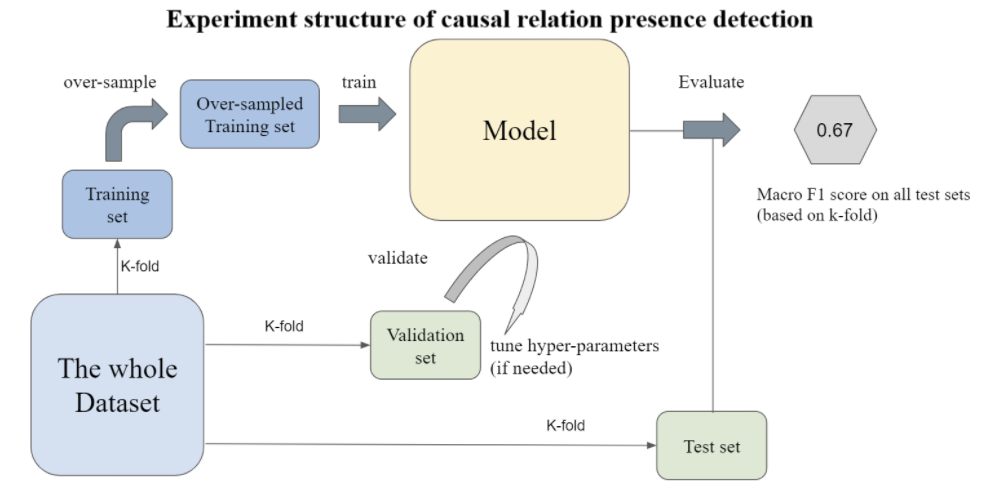
As shown in the Model processing flow above, we will only use over-sampling in a appropriate way: After using kfold spliting training set and test set, only the training set data will be over-sampled, which ensure that we won't have duplicate test data.

### 3. Training a Linear Classifier on paragraph-embeddings from a pre-trained BERT model
Our first step is to tokenize the paragraphs -- break them up into word and subwords in the format BERT is comfortable with. This process contains adding [CLS] and [SEP] tokens as well as substituting tokens with their IDs (tokens2IDs). <br><br>After tokenization, tokenized is a list of paragraphs -- each paragraph is represented as a list of tokens. And we want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths). <br><br>However, if we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. Finally, we will get our features from the last hidden state of BERT, and use them as the input to our classifier.

#### Let's now load a pre-trained BERT model.

In [8]:

# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights).cuda() #use .cpu here if you dont have GPU

#set random seed to keep consistency between different experiments
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
if str(device) == 'cuda':
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
else:
    torch.manual_seed(seed_val)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Using bert to get the last_hidden_states

In [9]:
def chunks(lst, n):
    """Using this to do batching"""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def get_max_len(batch):
    """
    use this to get the max length of all paragraphs in order to do the padding.
    """
    tokenized = batch['X'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    return max_len

def get_last_hidden_states(batch,max_len):
    """
    do Tokenization, Padding, and creating attention mask, then get the features from the last hidden states of BERT.
    Due to the GPU memory limitation, we will do this using batch.
    Input: data(in batch)
    output: features(in batch)
    """
    #Tokenization
    tokenized = batch['X'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    #Padding
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) #here max_len-len(i)=509 is the maximal length
    #use attention_mask to ignore (mask) the padding we've added when it's processing its input
    attention_mask = np.where(padded != 0, 1, 0)
    #tokens to IDs (then convert them to cuda)
    input_ids = torch.tensor(padded).cuda() #use .cpu here if you dont have GPU
    attention_mask = torch.tensor(attention_mask).cuda() #use .cpu here if you dont have GPU
    
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    #Get the features from the last hidden states
    features = last_hidden_states[0][:,0,:].cpu().numpy()
    return (features,batch)
        
def get_features(batch_1):
    """
    Get features from the last hidden states of BERT, we do this using batch.
    Input: whole data
    output: whole features
    """
    batch_size = 64
    f_cat = np.array([]) #array used to concat batches
    batch_turns = len(list(chunks(batch_1[:],batch_size)))
    max_len = get_max_len(batch_1) #get the maximal length of paragraphs
    for b in tqdm(range(batch_turns)):
        #print(f"Processed {b/batch_turns}")
        batch = list(chunks(batch_1[:],batch_size))[b]
        features,_ = get_last_hidden_states(batch,max_len)   
        f_cat =  np.concatenate((f_cat, features), axis=0)if f_cat.size else features
        #print('The shape of features(in batch) is {}'.format(f_cat.shape))
    return f_cat 

### Now use the features from the hidden states of BERT to feed a simple Logistic regression classifier

In [10]:
def classifier(X_train, y_train,X_test,y_test):

    lr=LogisticRegression()
    lr.fit(X_train, y_train)
    
    train_pred = lr.predict(X_train)
    eval_pred = lr.predict(X_test)
    

    return lr,train_pred,eval_pred,y_train,y_test 

In [11]:
def kfold_LR_Bert(X,y):
    """
    remove Missing value first, then output two balanced dataset (Undersampling and Oversampling)
    Input: X,y before pre-processing
    Output: dataframes after removing missing value, Undersampling and Oversampling
    """
    print('Preprocessing:\n')
    df = pd.DataFrame({'X':pd.Series(X),'y':pd.Series(y)})
    print('{} na data found'.format(len(df[df['X'].isna() == True].index)))
    df = df.dropna()
    print('na data dropped')
    
    
    kf = KFold(n_splits=5, random_state=seed_val, shuffle =True)
    kf.get_n_splits(df)
    
    
    training_pred = []
    training_true = []
    evaluation_pred = []
    evaluation_true = []

    k = 0

    
    for train_index, test_index in kf.split(df):\
        
        print('--------------------------------------------------------Now is {} fold--------------------------------------------------------'.format(k))
        
        X_train, X_test = df['X'][train_index], df['X'][test_index]
        y_train, y_test = df['y'][train_index], df['y'][test_index]
        
        print('[X training set shape, X test set shape]:',X_train.shape,X_test.shape)
        
        # over-sample the Training set, then transform them to right form
        df_train_upsampled = over_sampling(X_train, y_train)
        df_train_upsampled = transform_df(df_train_upsampled)
        
        # transform testset to right form
        df_test = pd.DataFrame({'X':pd.Series(X_test),'y':pd.Series(y_test)})
        df_test = transform_df(df_test)
        
        X_train = get_features(df_train_upsampled)
        y_train = df_train_upsampled['y']
        
        X_test = get_features(df_test)
        y_test = df_test['y']
        
        
        model,train_pred,eval_pred,train_label,eval_label = classifier(X_train, y_train,X_test,y_test)
        
        training_pred.append(train_pred)
        training_true.append(train_label)
        evaluation_pred.append(eval_pred)
        evaluation_true.append(eval_label)
        
        #this matters, otherwise you will face CUDA MEM ERRORS
        del model
        torch.cuda.empty_cache()
        
        k+=1
        
    def flatten(t):
        return [item for sublist in t for item in sublist]
    
    evaluation_true = flatten(evaluation_true)
    evaluation_pred = flatten(evaluation_pred)
    training_true = flatten(training_true)
    training_pred = flatten(training_pred)
    
    target_names = ['class 0', 'class 1']
    
    #For training data
    print('classification report on training set is:\n')
    clas_reprt_train = classification_report(training_true, training_pred, target_names=target_names)
    print(clas_reprt_train)
    
    #print('confusion matrix on training set is:\n')
    #cm_train = confusion_matrix(training_true, training_pred)
    #plot_confusion_matrix(cm_train, ['No causal relation', 'Has causal relation'], normalize=False)
    
    #For evaluation data
    print('classification report on test set is:\n')
    clas_reprt_eval = classification_report(evaluation_true, evaluation_pred, target_names=target_names)
    print(clas_reprt_eval)
    
    print('confusion matrix on test set is:\n')
    cm_eval = confusion_matrix(evaluation_true, evaluation_pred)
    plot_confusion_matrix(cm_eval, ['No causal relation', 'Has causal relation'], normalize=False)

    return 

Preprocessing:

19 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
We totally have 1012 training data after oversampling 


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
We totally have 1034 training data after oversampling 


100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)
We totally have 1044 training data after oversampling 


100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
We totally have 1006 training data after oversampling 


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


--------------------------------------------------------Now is 4 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)
We totally have 1032 training data after oversampling 


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


classification report on training set is:

              precision    recall  f1-score   support

     class 0       0.89      0.91      0.90      2564
     class 1       0.91      0.89      0.90      2564

    accuracy                           0.90      5128
   macro avg       0.90      0.90      0.90      5128
weighted avg       0.90      0.90      0.90      5128

classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.42      0.46      0.44       237
     class 1       0.79      0.76      0.78       641

    accuracy                           0.68       878
   macro avg       0.61      0.61      0.61       878
weighted avg       0.69      0.68      0.69       878

confusion matrix on test set is:



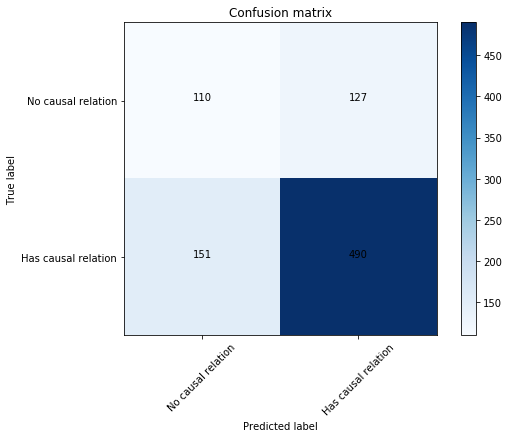

In [12]:
kfold_LR_Bert(X,y)

## Result


Model| training set macro precision | training set macro recall | training set macro F1| evaluation set macro precision | evaluation set macro recall | evaluation set macro F1|
----------| --------- | ------ | ---- | ---------|----------| --------- | 
LR+Bert_embedding   | 0.90         | 0.90    | <b>0.90</b> | 0.61 | 0.61 | <b>0.61</b> |
Bert           | 0.80        | 0.80     | <b>0.80</b> | 0.65 | 0.65 | <b>0.65</b> |




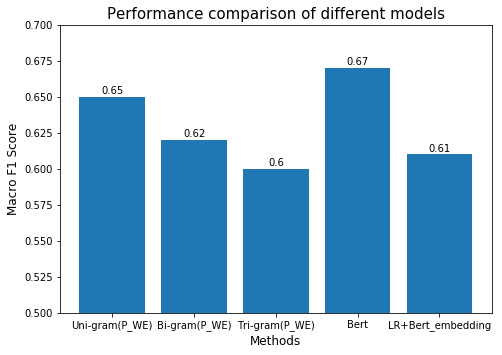

In [13]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

names = ['Uni-gram(P_WE)','Bi-gram(P_WE)','Tri-gram(P_WE)','Bert','LR+Bert_embedding']
scores = [0.65,0.62,0.60,0.67,0.61]

ax.bar(names, scores)
ax.set_ylabel('Macro F1 Score', fontsize=12)
ax.set_xlabel('Methods', fontsize=12)
ax.set_title('Performance comparison of different models', fontsize=15)
ax.set_ylim(0.5, 0.7)
for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x() + p.get_width() / 2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 1),
                    textcoords="offset points", ha="center", va="bottom")
plt.show()